In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import color
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [2]:
transform = transforms.Compose([transforms.Resize(320),
                                transforms.CenterCrop(320),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])
X = datasets.ImageFolder('./datasets/X/', transform=transform)
y = datasets.ImageFolder('./datasets/y/', transform=transform)
X_dataloader = torch.utils.data.DataLoader(X,
                                           batch_size=16,
                                           shuffle=False)
y_dataloader = torch.utils.data.DataLoader(y,
                                           batch_size=16,
                                           shuffle=False)
X_batched_data = iter(X_dataloader)
y_batched_data = iter(y_dataloader)

In [3]:
X = next(X_batched_data)[0]
y = next(y_batched_data)[0]

In [4]:
X.size()

torch.Size([16, 1, 320, 320])

In [5]:
y.size()

torch.Size([16, 1, 320, 320])

In [6]:
X

tensor([[[[0.6902, 0.6902, 0.6902,  ..., 0.8353, 0.8353, 0.8353],
          [0.6902, 0.6902, 0.6902,  ..., 0.8353, 0.8353, 0.8353],
          [0.6902, 0.6902, 0.6902,  ..., 0.8353, 0.8353, 0.8353],
          ...,
          [0.1098, 0.1098, 0.1098,  ..., 0.3176, 0.3176, 0.3176],
          [0.1098, 0.1098, 0.1098,  ..., 0.3176, 0.3176, 0.3176],
          [0.1098, 0.1098, 0.1098,  ..., 0.3176, 0.3176, 0.3176]]],


        [[[0.1490, 0.1490, 0.1490,  ..., 0.1804, 0.1804, 0.1804],
          [0.1490, 0.1490, 0.1490,  ..., 0.1804, 0.1804, 0.1804],
          [0.1490, 0.1490, 0.1490,  ..., 0.1804, 0.1804, 0.1804],
          ...,
          [0.0941, 0.0941, 0.0941,  ..., 0.0667, 0.0667, 0.0667],
          [0.0941, 0.0941, 0.0941,  ..., 0.0667, 0.0667, 0.0667],
          [0.0941, 0.0941, 0.0941,  ..., 0.0667, 0.0667, 0.0667]]],


        [[[0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9137],
          [0.9137, 0.9137, 0.9137,  ..., 0.9137, 0.9137, 0.9137],
          [0.9137, 0.9137, 0.9137,  ..

In [7]:
y

tensor([[[[0.5451, 0.5490, 0.5569,  ..., 0.5490, 0.5451, 0.5412],
          [0.5451, 0.5490, 0.5569,  ..., 0.5529, 0.5490, 0.5451],
          [0.5490, 0.5529, 0.5569,  ..., 0.5608, 0.5569, 0.5529],
          ...,
          [0.0706, 0.0706, 0.0667,  ..., 0.3569, 0.3765, 0.3569],
          [0.0784, 0.0706, 0.0588,  ..., 0.4078, 0.4000, 0.4196],
          [0.0824, 0.0745, 0.0588,  ..., 0.4588, 0.4392, 0.4510]]],


        [[[0.0706, 0.0706, 0.0706,  ..., 0.0667, 0.0667, 0.0667],
          [0.0784, 0.0784, 0.0784,  ..., 0.0706, 0.0706, 0.0706],
          [0.0824, 0.0824, 0.0824,  ..., 0.0745, 0.0745, 0.0745],
          ...,
          [0.0431, 0.0431, 0.0431,  ..., 0.0353, 0.0353, 0.0353],
          [0.0431, 0.0431, 0.0431,  ..., 0.0314, 0.0314, 0.0314],
          [0.0431, 0.0431, 0.0431,  ..., 0.0275, 0.0275, 0.0275]]],


        [[[0.9451, 0.9294, 0.9216,  ..., 0.9294, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
          [0.9255, 0.9255, 0.9216,  ..

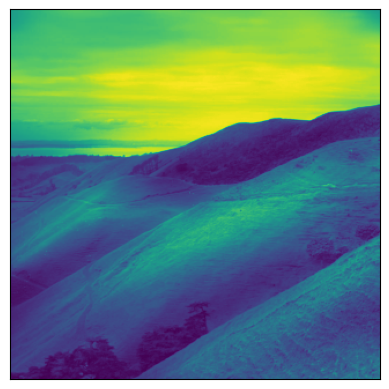

In [8]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.imshow(y[0].numpy().transpose((1, 2, 0)))

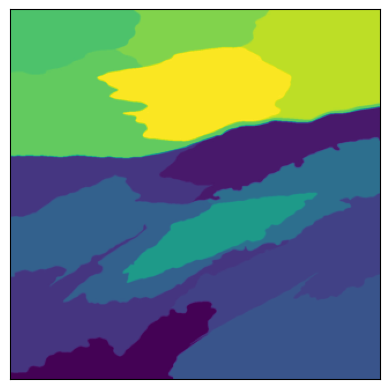

In [9]:
fig, ax = plt.subplots()
ax.tick_params(axis='both', length=0)
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.imshow(X[0].numpy().transpose((1, 2, 0)))

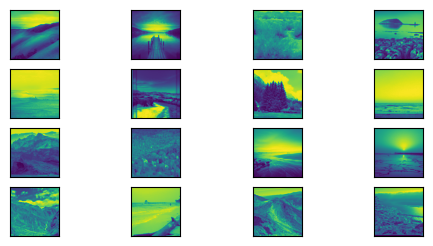

In [10]:
plt.figure(figsize=(6, 6))
for n, img in enumerate(y):
    ax = plt.subplot(8, 4, n + 1)

    ax.imshow(img.numpy().transpose((1, 2, 0)))
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

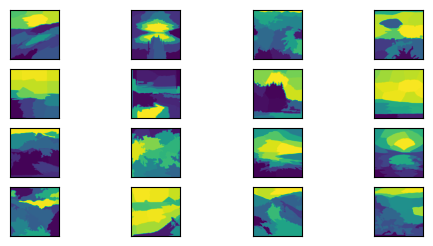

In [11]:
plt.figure(figsize=(6, 6))
for n, img in enumerate(X):
    ax = plt.subplot(8, 4, n + 1)

    ax.imshow(img.numpy().transpose((1, 2, 0)))
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [12]:
class Improver(torch.nn.Module):
    def __init__(self):
        super(Improver, self).__init__()
        self.fc1 = torch.nn.Linear(320 * 320, 4096)
        self.ac1 = torch.nn.LeakyReLU()
        self.fc2 = torch.nn.Linear(4096, 2048)
        self.ac2 = torch.nn.LeakyReLU()
        self.fc3 = torch.nn.Linear(2048, 320 * 320)
        self.ac3 = torch.nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 320 * 320)
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = x.view(-1, 1, 320, 320)
        x = self.ac3(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(nn.Linear(320 * 320, 512),
                                    nn.LeakyReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 128),
                                    nn.LeakyReLU())
        self.output = nn.Sequential(nn.Linear(128, 1),
                                    nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 320 * 320)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x

In [ ]:
D = Discriminator().to(device)
I = Improver().to(device)
loss = nn.BCELoss()

D_optimizer = torch.optim.SGD(D.parameters(), lr=0.003)
I_optimizer = torch.optim.Adam(I.parameters(), lr=0.003)
for e in range(30):
    for i, ((noises,_),(real,_)) in enumerate(zip(cycle(X_dataloader), y_dataloader)):
        real_inputs = real.to(device)
        real_outputs = D(real_inputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)
        noise = noises.to(device)
        fake_inputs = I(noise)
        fake_outputs = D(fake_inputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        D_loss = loss(outputs, targets)
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        fake_inputs = I(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        I_loss = loss(fake_outputs, fake_targets)
        I_optimizer.zero_grad()
        I_loss.backward()
        I_optimizer.step()
        if i % 100 == 0 or i == len(X_dataloader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(e, i, D_loss.item(), I_loss.item()))
    if (e+1) % 10 == 0:
        torch.save(I, 'Generator_epoch_{}.pth'.format(e))
        print('Model saved.')

Epoch 0 Iteration 0: discriminator_loss 0.694 generator_loss 0.754
Epoch 0 Iteration 100: discriminator_loss 0.021 generator_loss 4.478
Epoch 0 Iteration 200: discriminator_loss 0.015 generator_loss 5.493
Epoch 1 Iteration 0: discriminator_loss 0.027 generator_loss 4.175
Epoch 1 Iteration 100: discriminator_loss 0.006 generator_loss 5.729
Epoch 1 Iteration 200: discriminator_loss 0.010 generator_loss 6.287
Epoch 2 Iteration 0: discriminator_loss 0.003 generator_loss 6.630
Epoch 2 Iteration 100: discriminator_loss 0.002 generator_loss 6.986
Epoch 2 Iteration 200: discriminator_loss 0.005 generator_loss 7.185
Epoch 3 Iteration 0: discriminator_loss 0.001 generator_loss 7.361
Epoch 3 Iteration 100: discriminator_loss 0.001 generator_loss 7.573
Epoch 3 Iteration 200: discriminator_loss 0.004 generator_loss 7.687
Epoch 4 Iteration 0: discriminator_loss 0.001 generator_loss 7.801
Epoch 4 Iteration 100: discriminator_loss 0.000 generator_loss 7.955


In [ ]:
for i, ((noises,_),(real,_)) in enumerate(zip(cycle(X_dataloader), y_dataloader)):
    for img in noises:
        ax = plt.subplot(8, 4, n + 1)
    
        ax.imshow(img.numpy().transpose((1, 2, 0)))
        ax.tick_params(axis='both', length=0)
        ax.set_xticklabels("")
        ax.set_yticklabels("")
        #plt.imshow(noises[0].detach().numpy().squeeze())
    

In [ ]:
print(noise.view(-1,640*640).size())